# CIFAR and ImageNet Results

This notebook has the following structure:

1. Loads the log files from the CIFAR 10/100 and ImageNet experiments
2. Computes the obtained sketched overlaps, compared to the chance-level baselines
  1. As a function of training step
  2. As a function of overlap order (k)
3. Plots the `overlap / baseline` ratio

In [1]:
import collections
import itertools
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from tueplots import bundles, figsizes

In [2]:
# Seaborn setup
sns.set_theme(style="white")
colors = sns.color_palette()

## Prepare Data

In [3]:
def read_file(
    path,
    body_fn=lambda x: x,
    filter_headers=None,
    ts_colname="TIMESTAMP",
    header_colname="HEADER",
):
    """
    Load a log file into a pandas table. The file is assumed to be created
    by repeatedly calling the ``loj`` method, hence having lines in the
    form ``[timestamp, [header, body]]``.

    :param filter_headers: Collection of allowed headers. If given, only
      entries with these headers will be gathered.
    :param body_fn: The ``body`` entry from each line will be passed to
      this function for processing. The function must return a dictionary,
      such that all the returned key-value pairs will be aggregated into
      the output pandas table. If the body is already in the form of a
      dictionary, and you want to preserve all key-value pairs, this
      function is simply the identity. It can be used to filter out
      entries, rename keys, etc.
    :returns: A pandas dataframe, with ``ts_colname, header_colname``
      columns, as well as one column per key returned by ``body_fn``.
    """
    # first gather a list of [timestamp, [header, body]] entries
    entries = pd.read_json(path, lines=True).values.tolist()
    result = []
    for i, (ts, (header, body)) in enumerate(entries):
        if (filter_headers is not None) and (header not in filter_headers):
            continue
        body = body_fn(body)
        assert (ts_colname not in body) and (
            header_colname not in body
        ), "Colliding timestamp/header column names! {body.keys()}"
        try:
            result.append({ts_colname: ts, header_colname: header, **body})
        except TypeError:
            breakpoint()
            pass
    #
    result = pd.DataFrame(result)
    return result

In [4]:
def load_data(data_dir):
    results = {}
    for filename in os.listdir(data_dir):
        if "10d_core_and_analysis" in filename:
            # File path
            file_path = os.path.join(data_dir, filename)
            # Extract step
            step = read_file(file_path)["STEP"].dropna().item()
            assert step == int(step)
            step = int(step)
            # Extract train or test
            used_test = read_file(file_path)["TEST_HESSIAN"].dropna().item()
            split = "test" if used_test else "train"
            # Extract frob_Qtop^2
            frob = (
                read_file(file_path, filter_headers=["RESULT"])["frob_Qtop^2"]
                .dropna()
                .item()
            )
            # Store in dict
            if step not in results:
                results[step] = {}
            results[step][split] = frob

    all_iterations = list(results.keys())
    all_iterations.sort()
    print(f"Load data for iterations {all_iterations}")
    return results

In [5]:
DATA_DIR = "../output_analysis/"
CIFAR10_DIR = (
    DATA_DIR +
    "cifar10_nonaugmented_test+train_0_2000_to_8000/2024_02_01_16_29_36.956__cifar10det_3c3d__12345__64009/"
)
CIFAR10_CONFIG_FILE = (
    CIFAR10_DIR + "2024_02_01_16_29_36.958[10a_gather_params_grads.py].log")
D_CIFAR10 = 895_210
#
CIFAR100_DIR = (
    DATA_DIR +
    "cifar100_augmented_test_0_2000_to_8000/2024_02_01_12_56_43.988__cifar100_allcnnc__12345__63854/"
)
CIFAR100_CONFIG_FILE = (
    CIFAR100_DIR + "2024_02_01_12_56_43.991[10a_gather_params_grads.py].log")
D_CIFAR100 = 1_387_108
#
IMAGENET_DIR = (
    DATA_DIR +
    "resnet_nonaugmented_test_0_2000_to_8000/"
)
IMAGENET_CONFIG_FILE = (
    IMAGENET_DIR + "2024_05_14_19_56_44.438[10a_gather_params_grads.py].log")
D_IMAGENET = 11_689_512



# Load config
CIFAR10_CONFIG = read_file(CIFAR10_CONFIG_FILE, filter_headers=["CONFIG"])
CIFAR100_CONFIG = read_file(CIFAR100_CONFIG_FILE, filter_headers=["CONFIG"])
IMAGENET_CONFIG = read_file(IMAGENET_CONFIG_FILE, filter_headers=["CONFIG"])

cifar10_results = load_data(CIFAR10_DIR)
cifar100_results = load_data(CIFAR100_DIR)
imagenet_results = load_data(IMAGENET_DIR)

Load data for iterations [0, 2000, 4000, 6000, 8000]
Load data for iterations [0, 2000, 4000, 6000, 8000]
Load data for iterations [0, 2000, 4000, 6000, 8000]


## Plot

### Overlap vs. $k$ Plots

In [6]:
def plot_overlap_by_k(ax, data, D, iter, ax_title=None, xlabels=False, ylabel=None):
    """
    """
    max_k = len(data[iter]["test"])
    splits = list(data[iter].keys())
    # Plot measurements
    for split in splits:
        frob = data[iter][split]
        k = list(range(1, max_k))
        overlap = [i / j for i, j in zip(frob, k)]
        ax.plot(overlap, label=f"Sketched Overlap ({split.capitalize()})")
    # Plot baseline k/D
    baseline = [k / D for k in range(1, max_k)]
    ax.plot(baseline, label="Random Baseline", color="gray", linestyle="--")
    #
    ax.set_yscale("log")
    #
    if xlabels:  # for bottom row axes
        ax.set_xlabel(r"$k$")
    else:
        ax.set_xticks([])
        ax.set_xticks([], minor=True)
    #
    if ax_title is not None:  # for top row axes
        ax.set_title(ax_title)

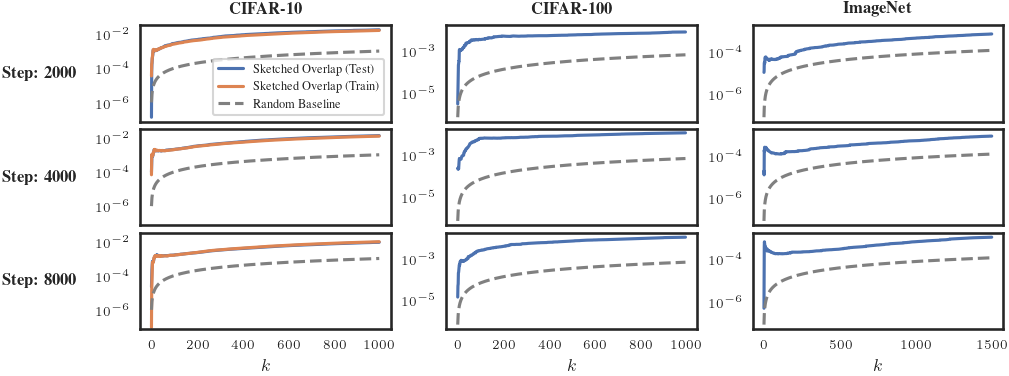

In [7]:
# TUEplots
nrows, ncols, hw_ratio = 3, 3, 3 / 8
plt.rcParams.update(bundles.icml2022(column="full"))
plt.rcParams.update(
    figsizes.icml2022_full(
        nrows=nrows,
        ncols=ncols,
        height_to_width_ratio=hw_ratio,
    ), )
plt.rcParams.update({"figure.constrained_layout.h_pad": 0.025})
plt.rcParams.update({"figure.constrained_layout.w_pad": 0.025})
plt.rcParams.update({"xtick.major.pad": -1})
plt.rcParams.update({"ytick.major.pad": -1})
plt.rcParams.update({"figure.dpi": 150})

fig, axs = plt.subplots(nrows=nrows, ncols=ncols)
#
plot_overlap_by_k(axs[0, 0], cifar10_results, D_CIFAR10, iter=2000, ax_title=r"\textbf{CIFAR-10}")
axs[0, 0].legend()
plot_overlap_by_k(axs[1, 0], cifar10_results, D_CIFAR10, iter=4000)
plot_overlap_by_k(axs[2, 0], cifar10_results, D_CIFAR10, iter=8000, xlabels=True)
axs[1, 0].set_ylim(axs[0, 0].get_ylim())
axs[2, 0].set_ylim(axs[0, 0].get_ylim())
#
plot_overlap_by_k(axs[0, 1], cifar100_results, D_CIFAR100, iter=2000, ax_title=r"\textbf{CIFAR-100}")
plot_overlap_by_k(axs[1, 1], cifar100_results, D_CIFAR100, iter=4000)
plot_overlap_by_k(axs[2, 1], cifar100_results, D_CIFAR100, iter=8000, xlabels=True)
axs[0, 1].set_ylim(axs[2, 1].get_ylim())
axs[1, 1].set_ylim(axs[2, 1].get_ylim())
#
plot_overlap_by_k(axs[0, 2], imagenet_results, D_IMAGENET, iter=2000, ax_title=r"\textbf{ImageNet}")
plot_overlap_by_k(axs[1, 2], imagenet_results, D_IMAGENET, iter=4000)
plot_overlap_by_k(axs[2, 2], imagenet_results, D_IMAGENET, iter=8000, xlabels=True)
axs[0, 2].set_ylim(axs[2, 2].get_ylim())
axs[1, 2].set_ylim(axs[2, 2].get_ylim())

#
xy_offset, fontsz = (-0.4, 0.43), 8
axs[0, 0].set_ylabel(r"\textbf{Step: 2000}", rotation=0, fontsize=fontsz)
axs[0, 0].yaxis.set_label_coords(*xy_offset)
axs[1, 0].set_ylabel(r"\textbf{Step: 4000}", rotation=0, fontsize=fontsz)
axs[1, 0].yaxis.set_label_coords(*xy_offset)
axs[2, 0].set_ylabel(r"\textbf{Step: 8000}", rotation=0, fontsize=fontsz)
axs[2, 0].yaxis.set_label_coords(*xy_offset)

# Save and show
# fig.tight_layout()
fig.savefig("plot_output/overlaps_by_k.pdf")
plt.show()

### Overlap vs. Iteration Plot

In [8]:
def flip(items, ncol):
    return itertools.chain(*[items[i::ncol] for i in range(ncol)])

def plot_overlap_iter(ax, data, D, ks):
    splits = list(data[2000].keys())
    splits.sort(reverse=True)
    for k_idx, k in enumerate(ks):
        # Store results in dict
        for split in splits:
            results_k = {}
            for iters in data.keys():
                frob = data[iters][split][k]
                overlap = frob / k

                results_k[iters] = overlap

            # Sort
            sorted_results_k = collections.OrderedDict(sorted(results_k.items()))
            ls = ":" if split == "train" else "-"

            # Plot
            ax.plot(
                sorted_results_k.keys(),
                sorted_results_k.values(),
                label=rf"$k={k}$ ({split.capitalize()})",
                color=colors[k_idx],
                linestyle=ls,
            )

            # Plot Baseline
            if split == "test":
                ax.plot(
                    sorted_results_k.keys(),
                    [k / D for _ in sorted_results_k.keys()],
                    label=rf"$k={k}$ (Random Baseline)",
                    color=colors[k_idx],
                    alpha=0.5,
                    linestyle="--",
                )

    ax.set_yscale("log")
    #
    handles, labels = ax.get_legend_handles_labels()
    return handles, labels

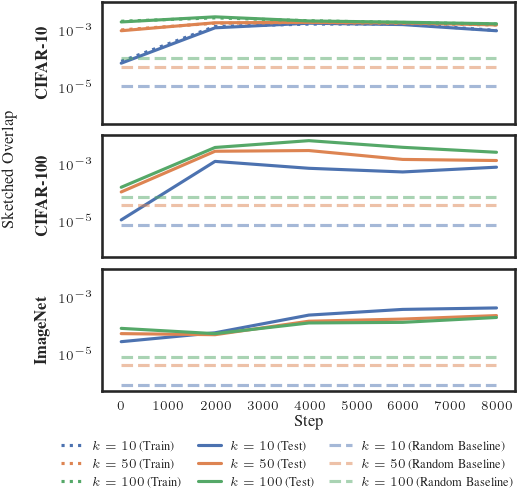

In [9]:
ncols = 1
nrows = 3
ratio = 0.3

# TUEplots
plt.rcParams.update(bundles.icml2022(column="half"))
plt.rcParams.update(
    figsizes.icml2022_half(
        nrows=nrows,
        ncols=ncols,
        height_to_width_ratio=ratio,
    ),
)
plt.rcParams.update({"figure.constrained_layout.h_pad": 0.025})
plt.rcParams.update({"figure.constrained_layout.w_pad": 0.025})
plt.rcParams.update({"xtick.major.pad": -1})
plt.rcParams.update({"ytick.major.pad": -1})
plt.rcParams.update({"figure.dpi": 150})

fig, axs = plt.subplots(nrows, ncols, sharex=True, sharey=True)

h, l = plot_overlap_iter(
    axs[0], 
    cifar10_results, 
    D_CIFAR10, 
    ks=[10, 50, 100]
)
plot_overlap_iter(axs[1],
                  cifar100_results,
                  D_CIFAR100,
                  ks=[10, 50, 100])
plot_overlap_iter(axs[2],
                  imagenet_results,
                  D_IMAGENET,
                  ks=[10, 50, 100])

#
axs[0].set_ylabel(r"\textbf{CIFAR-10}")
axs[1].set_ylabel(r"\textbf{CIFAR-100}")
axs[2].set_ylabel(r"\textbf{ImageNet}")
axs[2].set_xlabel("Step", labelpad=1)
# Polish
legend_cols = 3
legend_height = 0.05
fig.legend(flip(h, legend_cols), 
           flip(l, legend_cols), 
           bbox_to_anchor=(1.05, legend_height),
           ncols=legend_cols, 
           frameon=False, 
           borderaxespad=2,
           columnspacing=1.2,
           handlelength=1.8)


fig.text(-0.06, 0.6, "Sketched Overlap", va="center", rotation="vertical")

# Save and show
plt.savefig("plot_output/overlaps_by_t.pdf")
plt.show()

### Higher than Baseline Factor vs. k

In [10]:
def plot_fraction_k(ax, data, D, plot_iters, xlabels=False):
    # Plot measurements
    splits = list(data[plot_iters[0]].keys())
    splits.sort(reverse=True)
    for iter_idx, iters in enumerate(plot_iters):
        for split in splits:
            frob = data[iters][split]
            max_k = len(frob)
            k = list(range(1, max_k))
            overlap = [i / j for i, j in zip(frob, k)]
            baseline = [k / D for k in range(1, max_k)]
            ratio = [i / j for i, j in zip(overlap, baseline)]

            ls = ":" if split == "train" else "-"
            ax.plot(
                ratio,
                label=f"Step {iters} ({split.capitalize()})",
                color=colors[iter_idx],
                linestyle=ls,
            )
    #
    if xlabels:  # for bottom row axes
        ax.set_xlabel(r"$k$")
    else:
        ax.set_xticks([])
        ax.set_xticks([], minor=True)
    ax.set_yscale("log")
    handles, labels = ax.get_legend_handles_labels()
    return handles, labels            


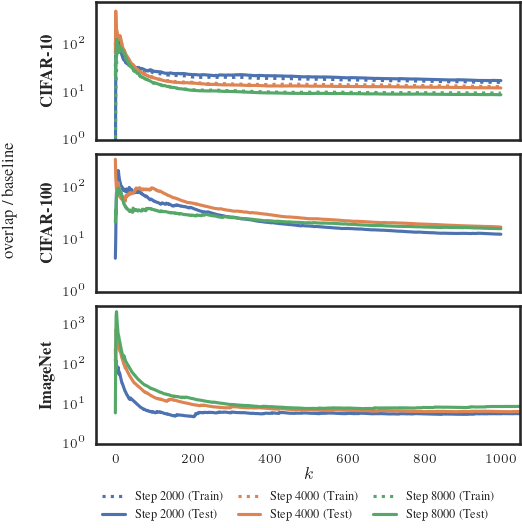

In [11]:
ncols = 1
nrows = 3
ratio = 1 / 3

# TUEplots
plt.rcParams.update(bundles.icml2022(column="half"))
plt.rcParams.update(
    figsizes.icml2022_half(
        nrows=nrows,
        ncols=ncols,
        height_to_width_ratio=ratio,
    ), )
plt.rcParams.update({"figure.constrained_layout.h_pad": 0.025})
plt.rcParams.update({"figure.constrained_layout.w_pad": 0.025})
plt.rcParams.update({"xtick.major.pad": -1})
plt.rcParams.update({"ytick.major.pad": -1})
plt.rcParams.update({"figure.dpi": 150})

fig, axs = plt.subplots(nrows, ncols)


h, l = plot_fraction_k(axs[0],
                       cifar10_results,
                       D_CIFAR10,
                       plot_iters=[2000, 4000, 8000])
plot_fraction_k(axs[1],
                cifar100_results,
                D_CIFAR100,
                plot_iters=[2000, 4000, 8000])
plot_fraction_k(axs[2],
                imagenet_results,
                D_IMAGENET,
                plot_iters=[2000, 4000, 8000],
               xlabels=True)

axs[0].set_ylabel(r"\textbf{CIFAR-10}")
axs[1].set_ylabel(r"\textbf{CIFAR-100}")
axs[2].set_ylabel(r"\textbf{ImageNet}")
axs[2].set_xlabel(r"$k$", labelpad=1)
#
axs[0].set_ylim((1, None))
axs[1].set_ylim((1, None))
axs[2].set_ylim((1, None))
#
axs[0]
axs[2].set_xlim((axs[0].get_xlim()))

# Save and show
legend_cols = 3
legend_height = 0.05
fig.legend(h,
           l, 
           bbox_to_anchor=(1, legend_height),
           ncols=legend_cols, 
           frameon=False, 
           borderaxespad=2,
           columnspacing=1.2,
           handlelength=1.8)

fig.text(-0.07, 0.585, "overlap / baseline", va="center", rotation="vertical")
plt.savefig("plot_output/overlap_factor.pdf")
plt.show()

# Joint plot: overlap-by-step and overlap ratio

* We move the axis main y-label to axis title
* Remove the axis y-sublables from right column

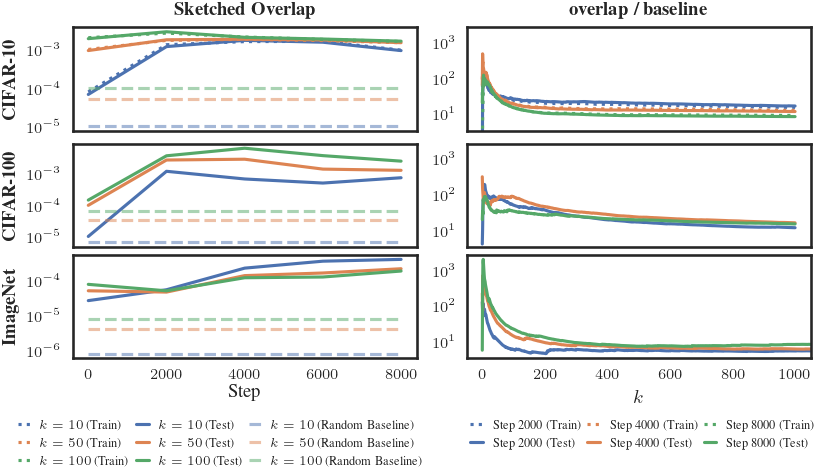

In [12]:
ncols = 2
nrows = 3
hw_ratio = 1 / 3

# TUEplots
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(
    figsizes.neurips2022(
        nrows=nrows,
        ncols=ncols,
        height_to_width_ratio=hw_ratio,
    ),
)
plt.rcParams.update({"figure.constrained_layout.h_pad": 0.025})
plt.rcParams.update({"figure.constrained_layout.w_pad": 0.05})
plt.rcParams.update({"xtick.major.pad": -1})
plt.rcParams.update({"ytick.major.pad": -1})
plt.rcParams.update({"figure.dpi": 150})

fig, axs = plt.subplots(nrows, ncols)

h, l = plot_overlap_iter(
    axs[0, 0], 
    cifar10_results, 
    D_CIFAR10, 
    ks=[10, 50, 100]
)
plot_overlap_iter(axs[1, 0],
                  cifar100_results,
                  D_CIFAR100,
                  ks=[10, 50, 100])
plot_overlap_iter(axs[2, 0],
                  imagenet_results,
                  D_IMAGENET,
                  ks=[10, 50, 100])

#
axs[0, 0].set_ylabel(r"\textbf{CIFAR-10}")
axs[1, 0].set_ylabel(r"\textbf{CIFAR-100}")
axs[2, 0].set_ylabel(r"\textbf{ImageNet}")
axs[2, 0].set_xlabel("Step", labelpad=1)
#
# axs[0, 0].set_ylim(axs[1, 0].get_ylim())
# axs[2, 0].set_ylim(axs[1, 0].get_ylim())
# axs[2, 0].set_ylim(0.5 * 1e-6, 1e-3)
#
axs[0, 0].set_xticks([])
axs[0, 0].set_xticks([], minor=True)
axs[1, 0].set_xticks([])
axs[1, 0].set_xticks([], minor=True)

# Polish
fontsz = 6
legend_cols = 3
legend_height = 0.05
fig.legend(flip(h, legend_cols), 
           flip(l, legend_cols), 
           bbox_to_anchor=(0.555, legend_height),
           ncols=legend_cols, 
           frameon=False, 
           borderaxespad=2,
           columnspacing=0.5,
           prop={"size": fontsz},
           handlelength=1)


axs[0, 0].set_title(r"\textbf{Sketched Overlap}", fontsize=9)


#
h, l = plot_fraction_k(axs[0, 1],
                       cifar10_results,
                       D_CIFAR10,
                       plot_iters=[2000, 4000, 8000])
plot_fraction_k(axs[1, 1],
                cifar100_results,
                D_CIFAR100,
                plot_iters=[2000, 4000, 8000])
plot_fraction_k(axs[2, 1],
                imagenet_results,
                D_IMAGENET,
                plot_iters=[2000, 4000, 8000],
               xlabels=True)
#
axs[0, 1].set_ylim(axs[2, 1].get_ylim())
axs[1, 1].set_ylim(axs[2, 1].get_ylim())
axs[1, 1].set_xlim((axs[0, 1].get_xlim()))
axs[2, 1].set_xlim((axs[0, 1].get_xlim()))
#
axs[0, 1].set_title(r"\textbf{overlap / baseline}", fontsize=9)
#
fontsz = 6
legend_cols = 3
legend_height = 0.05
fig.legend(h,
           l, 
           bbox_to_anchor=(1.03, legend_height),
           ncols=legend_cols, 
           frameon=False, 
           borderaxespad=2,
           columnspacing=0.5,
           prop={"size": fontsz},
           handlelength=1)

# Save and show
plt.savefig("plot_output/overlaps_by_t_and_ratios.pdf")
plt.show()